In [1]:
import random             # For random testcase generate
import time               # For time measure
import signal             # For timeout signal
import contextlib         # For timeout with 
#import pygal             # For visualize the differnce between algorithms
# If you don't have pygal, scoll down to cell[13] see result first
from math import floor    # For floor

In [2]:
# For catch timeout
class TimedOut(Exception):
    pass

def handler(signum, frame):
    raise TimedOut

# control with statement
@contextlib.contextmanager
def timeout(seconds, function):
    signal.signal(signal.SIGALRM, handler)
    signal.alarm(seconds)
    try:
        yield
        signal.alarm(0)
    except TimedOut:
        print(f'{function.__name__:>20} Timeout')

In [3]:
# Class Test Case
# usage:
# testcase = TestCase(scale)
# testcase.verify_random(fun_name)
# testcase.verify_sorted(fun_name)
class TestCase:
    passed_strings = ['Wrong Answer', 'Accepted']
    
    def __init__(self, size):
        self.data = [random.randrange(1000000) for i in range(size)] # random data
        start = time.perf_counter()
        self.sorted = sorted(self.data)                              # sorted data
        end = time.perf_counter()
        print('Time of Python built-in function sorted() is ', end-start, ' second')
        self.local_copy = [] 
        
    def verify_random(self, function):
        start = time.perf_counter()              # start timer
        self.local_copy = list(self.data)        # copy random data for sort
        with timeout(200, function):
            function(self.local_copy)                # use your sort algorithm to sort
            passed = self.sorted == self.local_copy  # judge
            stop = time.perf_counter()               # end timer
            print(f'{function.__name__:>20} {self.passed_strings[passed]:12} {stop - start:6g}')
            return stop - start
        
    def verify_sorted(self, function):
        start = time.perf_counter()
        self.local_copy = list(self.sorted)
        with timeout(20, function):
            function(self.local_copy)
            passed = self.sorted == self.local_copy
            stop = time.perf_counter()
            print(f'{function.__name__:>20} {self.passed_strings[passed]:12} {stop - start:6g}')
            return stop - start
        return None

In [4]:
# bubble sort
def bubble_sort(list_):
    # length of list_
    length = len(list_)
    while True:
        swapped = False # a flag to check whether converged
        for i in range(1, length):
            if list_[i - 1] > list_[i]: # bubble
                list_[i - 1], list_[i] = list_[i], list_[i - 1]
                swapped = True
        if swapped == False:
            break

In [5]:
# a version of optimized bubble sort
# the optimized method is bubble up without only one bubble
def comb_sort(list_):
    
    length = len(list_)    
    gap = len(list_) # the range that a bubble up comparsion
    shrink = 1.3     # shrink factor
    sorted_ = False
    
    while sorted_ == False:
        gap = floor(gap / shrink)
        if gap > 1:
            sorted_ = False
        else:
            gap = 1
            sorted_ = True
        index = 0
        while index + gap < length:
            if list_[index] > list_[index + gap]:
                list_[index], list_[index + gap] = list_[index + gap], list_[index]
                sorted_ = False
            index += 1

In [6]:
# merge two sorted list
def merge(list_, start, mid, end):
    nl = mid - start
    nr = end - mid
    
    left = list_[start:mid]
    left.append(float('inf')) # for sential
    right = list_[mid:end]
    right.append(float('inf')) # for sential
        
    l = 0
    r = 0
    
    for i in range(start, end):
        if (left[l] <= right[r]):
            list_[i] = left[l]
            l += 1
        else:
            list_[i] = right[r]
            r += 1

# merge sort, with two optional arguments for intenal use
def merge_sort(list_, start = 0, end = None):
    if end == None:
        end = len(list_)
    if start + 1 == end:
        return
    
    mid = (start + end) // 2
    merge_sort(list_, start, mid)
    merge_sort(list_, mid, end)
    merge(list_, start, mid, end)

In [7]:
# a common partition method, take the last one as pivot
def partition(list_, start, end):
    pivot = list_[end]
    i = start - 1
    for j in range(start, end):
        if list_[j] <= pivot:
            i += 1
            list_[i], list_[j] = list_[j], list_[i]
    list_[i + 1], list_[end] = list_[end], list_[i + 1]
    return i + 1

# With stack optimization to avoid the sorted test to run out of stack
# With stack optimization is slower
# Another solution is use sys.setrecursionlimit(depth), however, I prefer current way
def quick_sort(list_, start = 1, end = None):
    remove_flag = False
    if end == None:
        end = len(list_)
        remove_flag = True
        list_.insert(0, -1) # dummy for 1 index base
    while (start < end):
        p = partition(list_, start, end)
        lsize =  p - start
        rsize = end - p
        if ( lsize < rsize ):
            quick_sort(list_, start, p - 1)
            start = p + 1
        else:
            quick_sort(list_, p + 1, end)
            end = p - 1
    if remove_flag == True:
        list_.remove(-1)

In [8]:
# heapify a node with index i
def min_heapify(list_, i, heap_size):
    l = 2 * i
    r = 2 * i + 1    
    
    if l <= heap_size and list_[l] > list_[i]:
            smallest = l
    else:
        smallest = i
    
    if r <= heap_size and list_[r] > list_[smallest]:
        smallest = r
    
    if smallest != i:
        list_[i], list_[smallest] = list_[smallest], list_[i]
        min_heapify(list_, smallest, heap_size)
    
# build the heap by min 
def build_min_heap(list_):
    heap_size = len(list_)
    list_.insert(0, -1) # dummy for 1 index base
    for i in range(len(list_)//2, 0, -1):
        min_heapify(list_, i, heap_size)
    return heap_size

# heap sort, build_heap first, and heapify from len(list_) to 2
def heap_sort(list_):
    heap_size = build_min_heap(list_)
    for i in range(len(list_), 1, -1):
        list_[1], list_[i - 1], = list_[i - 1], list_[1]
        heap_size -= 1
        min_heapify(list_, 1, heap_size)
    list_.remove(-1)

In [9]:
# Python is too slow, use Cython and O3 flag to accelerate
%load_ext Cython

In [10]:
%%cython --compile-args=-O3 --link-args=-O3

# the following code is mostly same as above, with type hint only
from math import floor

cpdef comb_sort_c(list list_):
    
    length = len(list_)    
    gap = len(list_) # the range that a bubble up comparsion
    shrink = 1.3     # shrink factor
    sorted_ = False
    
    while sorted_ == False:
        gap = floor(gap / shrink)
        if gap > 1:
            sorted_ = False
        else:
            gap = 1
            sorted_ = True
        index = 0
        while index + gap < length:
            if list_[index] > list_[index + gap]:
                list_[index], list_[index + gap] = list_[index + gap], list_[index]
                sorted_ = False
            index += 1
            
cpdef list_sort_c(list list_):
    list_.sort()
    
cpdef merge_c(list list_, int start, int mid, int end):
    cdef int nl = mid - start
    cdef int nr = end - mid
    
    cdef list left = list_[start:mid]
    left.append(float('inf')) # for sential
    cdef list right = list_[mid:end]
    right.append(float('inf')) # for sential
        
    cdef int l = 0
    cdef int r = 0
    cdef int i
    
    for i in range(start, end):
        if (left[l] <= right[r]):
            list_[i] = left[l]
            l += 1
        else:
            list_[i] = right[r]
            r += 1

cpdef merge_sort_c(list list_, start = 0, end = None):
    if end == None:
        end = len(list_)
    if start + 1 == end:
        return
    
    cdef int mid = (start + end) // 2
    merge_sort_c(list_, start, mid)
    merge_sort_c(list_, mid, end)
    merge_c(list_, start, mid, end)
    
cpdef partition_c(list list_, int start, int end):
    cdef int pivot = list_[end]
    cdef int i = start - 1
    cdef int j
    
    for j in range(start, end):
        if list_[j] <= pivot:
            i += 1
            list_[i], list_[j] = list_[j], list_[i]
    list_[i + 1], list_[end] = list_[end], list_[i + 1]
    return i + 1


cpdef quick_sort_c(list list_, int start = 1, end = None):
    remove_flag = False
    if end == None:
        end = len(list_)
        remove_flag = True
        list_.insert(0, -1) # dummy for 1 index base
    while (start < end):
        p = partition_c(list_, start, end)
        lsize =  p - start
        rsize = end - p
        if ( lsize < rsize ):
            quick_sort_c(list_, start, p - 1)
            start = p + 1
        else:
            quick_sort_c(list_, p + 1, end)
            end = p - 1
    if remove_flag == True:
        list_.remove(-1)
            
cpdef min_heapify_c(list list_, int i, int heap_size):
    cdef int l = 2 * i
    cdef int r = 2 * i + 1    
    cdef smallest
    
    if l <= heap_size and list_[l] > list_[i]:
            smallest = l
    else:
        smallest = i
    
    if r <= heap_size and list_[r] > list_[smallest]:
        smallest = r
    
    if smallest != i:
        list_[i], list_[smallest] = list_[smallest], list_[i]
        min_heapify_c(list_, smallest, heap_size)
    
cpdef build_min_heap_c(list list_):
    cdef int heap_size = len(list_)
    list_.insert(0, -1) # dummy for 1 index base
    for i in range(len(list_)//2, 0, -1):
        min_heapify_c(list_, i, heap_size)
    return heap_size

cpdef heap_sort_c(list_):
    cdef int heap_size
    heap_size = build_min_heap_c(list_)
    for i in range(len(list_), 1, -1):
        list_[1], list_[i - 1], = list_[i - 1], list_[1]
        heap_size -= 1
        min_heapify_c(list_, 1, heap_size)
    list_.remove(-1)
    
cpdef bubble_sort_c(list list_):
    cdef int length = len(list_)
    while True:
        swapped = False # a flag to check whether converged
        for i in range(1, length):
            if list_[i - 1] > list_[i]:
                list_[i - 1], list_[i] = list_[i], list_[i - 1]
                swapped = True
        if swapped == False:
            break

In [11]:
# This cell used to test 6 algorithm with python 3.6
function_list = [list.sort, heap_sort, comb_sort, merge_sort, quick_sort, bubble_sort]

# analysis dictionary for later visualizaion
analysis_data = {}
analysis_data['random_1K'] = []
analysis_data['sorted_1K'] = []
analysis_data['random_1M'] = []
analysis_data['sorted_1M'] = []
analysis_data['random_10M'] = []

analysis_data['random_1K_c'] = []
analysis_data['sorted_1K_c'] = []
analysis_data['random_1M_c'] = []
analysis_data['sorted_1M_c'] = []
analysis_data['random_10M_c'] = []
# For 1K random testcase
print('Test with 1K random testcase')
print(79*'-')
testcase = TestCase(1000)
for fun in function_list:
    analysis_data['random_1K'].append(testcase.verify_random(fun))
print()

# For 1M sorted testcase
print('Test with 1K sorted testcase')
print(79*'-')
testcase = TestCase(1000)
for fun in function_list:
    analysis_data['sorted_1K'].append(testcase.verify_sorted(fun))
print()

# For 1M random testcase
# bubble sort will Timeout, because of n^2 algorithm
print('Test with 1M random testcase')
print(79*'-')
testcase = TestCase(1000000)
for fun in function_list:
    analysis_data['random_1M'].append(testcase.verify_random(fun))
print()

# For 1M sorted testcase
# quick_sort for sorted testcase is n^2 will timeout
# bubble sort has terminated statement, so sorted testcase will terminate immediately
print('Test with 1M sorted testcase')
print(79*'-')
for fun in function_list:
    analysis_data['sorted_1M'].append(testcase.verify_sorted(fun))
print()

# For 10M random testcase
# 200 second will TLE
# heap sort and comb sort has more constant factor
# bubble sort will timeout because of n^2 algorithm
print('Test with 10M random testcase')
print(79*'-')
testcase = TestCase(10000000)
for fun in function_list:
    analysis_data['random_10M'].append(testcase.verify_random(fun))
print()

Test with 1K random testcase
-------------------------------------------------------------------------------
Time of Python built-in function sorted() is  0.00015492099919356406  second
                sort Accepted     0.000188169
           heap_sort Accepted     0.00368908
           comb_sort Accepted     0.0036225
          merge_sort Accepted     0.00285684
          quick_sort Accepted     0.00174815
         bubble_sort Accepted     0.101932

Test with 1K sorted testcase
-------------------------------------------------------------------------------
Time of Python built-in function sorted() is  0.00014892900071572512  second
                sort Accepted     4.4332e-05
           heap_sort Accepted     0.00388314
           comb_sort Accepted     0.0021778
          merge_sort Accepted     0.00249413
          quick_sort Accepted     0.0676322
         bubble_sort Accepted     0.000107837

Test with 1M random testcase
------------------------------------------------------------

In [12]:
# This cell is run above algorithm with Cython with 1M random testcase
function_list = [list_sort_c, heap_sort_c, comb_sort_c, merge_sort_c, quick_sort_c]

# For 1M random testcase
print('Test with 1M random testcase')
print(79*'-')
testcase = TestCase(1000000)
for fun in function_list:
    analysis_data['random_1M_c'].append(testcase.verify_random(fun))

Test with 1M random testcase
-------------------------------------------------------------------------------
Time of Python built-in function sorted() is  0.4338104830021621  second
         list_sort_c Accepted     0.442479
         heap_sort_c Accepted     2.85071
         comb_sort_c Accepted     9.57475
        merge_sort_c Accepted     1.1314
        quick_sort_c Accepted     1.17351


In [13]:
import pygal # For visualize the differnce between algorithms

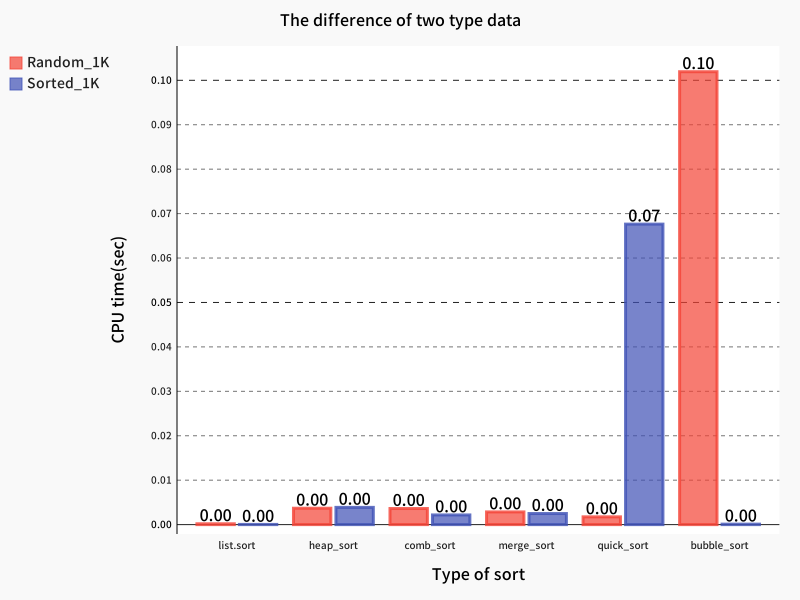

In [14]:
# This cell is the comparation of 1K testcase
chart = pygal.Bar(stroke_style={'width': 3}, print_values=True, value_formatter=lambda x : '{0:.2f}'.format(x),
                 print_None=True, print_values_position='top')
chart.title = 'The difference of two type data'
chart.y_title = 'CPU time(sec)'
chart.x_title = 'Type of sort'
chart.x_labels = ['list.sort', 'heap_sort', 'comb_sort', 'merge_sort', 'quick_sort', 'bubble_sort']
chart.add('Random_1K', analysis_data['random_1K'])
chart.add('Sorted_1K', analysis_data['sorted_1K'])

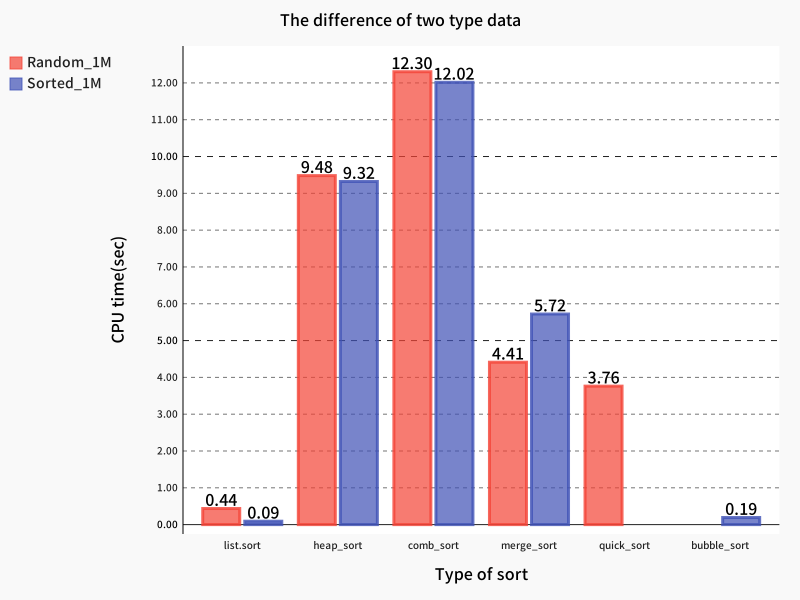

In [15]:
# This cell is the comparation of 1M testcase
chart = pygal.Bar(stroke_style={'width': 3}, print_values=True, value_formatter=lambda x : '{0:.2f}'.format(x),
                 print_None=True, print_values_position='top')
chart.title = 'The difference of two type data'
chart.y_title = 'CPU time(sec)'
chart.x_title = 'Type of sort'
chart.x_labels = ['list.sort', 'heap_sort', 'comb_sort', 'merge_sort', 'quick_sort', 'bubble_sort']
chart.add('Random_1M', analysis_data['random_1M'])
chart.add('Sorted_1M', analysis_data['sorted_1M'])

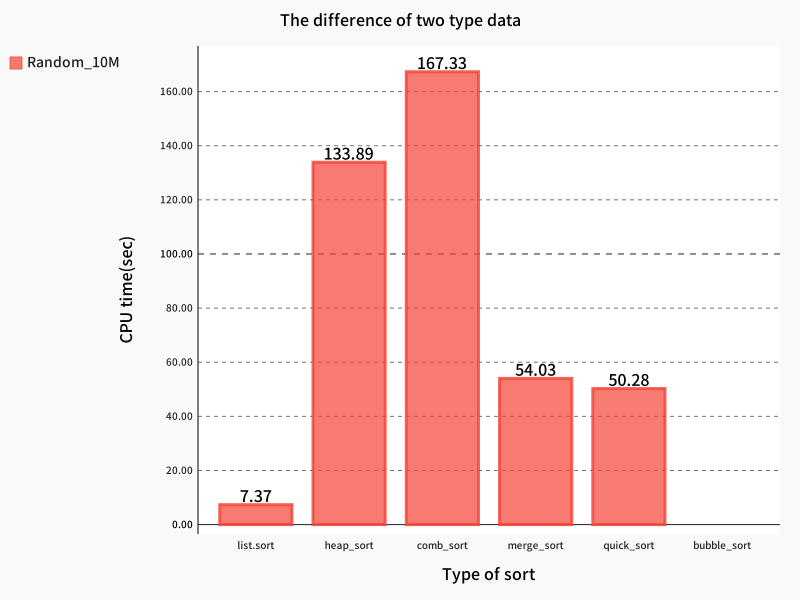

In [17]:
# This cell is the comparation of 10M testcase
chart = pygal.Bar(stroke_style={'width': 3}, print_values=True, value_formatter=lambda x : '{0:.2f}'.format(x),
                 print_None=True, print_values_position='top')
chart.title = 'The difference of two type data'
chart.y_title = 'CPU time(sec)'
chart.x_title = 'Type of sort'
chart.x_labels = ['list.sort', 'heap_sort', 'comb_sort', 'merge_sort', 'quick_sort', 'bubble_sort']
chart.add('Random_10M', analysis_data['random_10M'])

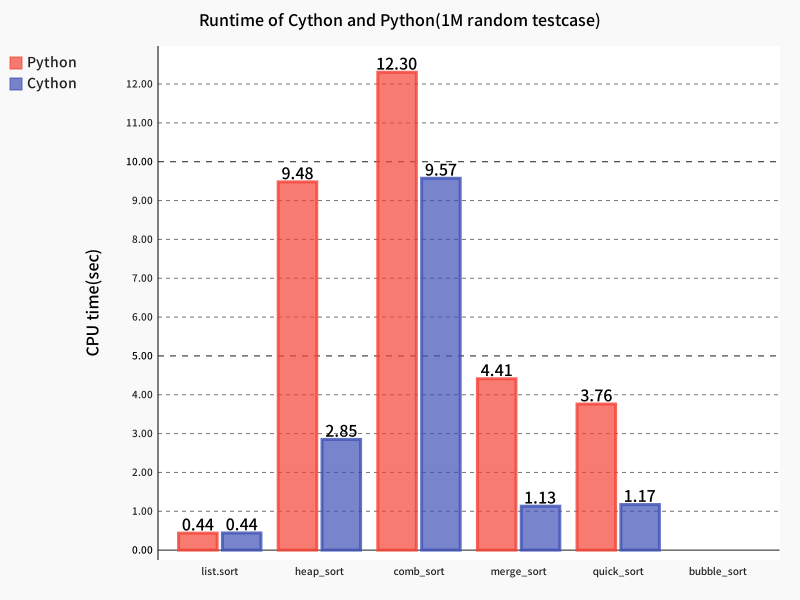

In [18]:
# This cell is the comparation of python and cython
chart = pygal.Bar(stroke_style={'width': 3}, print_values=True, value_formatter=lambda x : '{0:.2f}'.format(x),
                 print_None=True, print_values_position='top')
chart.title = 'Runtime of Cython and Python(1M random testcase)'
chart.y_title = 'CPU time(sec)'
chart.x_labels = ['list.sort', 'heap_sort', 'comb_sort', 'merge_sort', 'quick_sort', 'bubble_sort']
chart.add('Python', analysis_data['random_1M'])
chart.add('Cython', analysis_data['random_1M_c'])